In [13]:
# import libraries
import numpy as np
import mahotas
import cv2
import os
import h5py
from skimage.feature import hog
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import pandas as pd

import warnings
warnings.filterwarnings("ignore")


In [2]:
def processing_color_histogram(image):
    hist  = cv2.calcHist([image], [0,1,2],None,[8,8,8],[0,256,0,256,0,256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def processing_hog(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return hog(image)

def processing_haralick(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return mahotas.features.haralick(gray).mean(axis=0)

In [20]:
img_size = tuple((256,256))
hog_size=tuple((100,100))
test_size = 0.10 # train_test_split size

def process_image(image):
    resized_image = cv2.resize(image, img_size)
    resized_hog= cv2.resize(image, hog_size)
    blur_img = cv2.GaussianBlur(resized_image, (5, 5), 0)
    color_historgram_vector  = processing_color_histogram(blur_img)
    haralick_vector = processing_haralick(blur_img)
    hstack = np.hstack([color_historgram_vector, haralick_vector])
    hog_vector = processing_hog(resized_hog)
    return hstack,hog_vector

def normalize_features(features):
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(features)

In [4]:
import os
path = 'train'
label=[]
global_col=[]
global_hog=[]
for folder in os.listdir(path):
    if folder!=".DS_Store":
        imgpath=os.path.join(path,folder)
        for filename in os.listdir(imgpath):
            if filename !=".DS_Store":
                img=cv2.imread(os.path.join(imgpath, filename))
                c=[]
                l=[]
                (c,l)=process_image(img)
                global_col.append(c)
                global_hog.append(l)
                label.append(folder)

In [15]:
from sklearn.preprocessing import LabelEncoder
targetNames=np.unique(label)
le=LabelEncoder()
target=le.fit_transform(label)

In [6]:
h5f_data=h5py.File("col.h5","w")
h5f_data.create_dataset("dataset_1",data=np.array(global_col))

h5f_data.close()

h5f_data=h5py.File("hog.h5","w")
h5f_data.create_dataset("dataset_1",data=np.array(global_hog))

h5f_data.close()



TypeError: No conversion path for dtype: dtype('<U9')

In [8]:
h5f_data=h5py.File("label.h5","w")
h5f_data.create_dataset("dataset_1",data=np.array(target))

h5f_data.close()

In [14]:
h5f_data=h5py.File("col.h5","r")
global_cold=h5f_data["dataset_1"]
global_col=np.array(global_cold)
h5f_data.close()

h5f_data=h5py.File("hog.h5","r")
global_hogd=h5f_data["dataset_1"]
global_hog=np.array(global_hogd)
h5f_data.close()

h5f_data=h5py.File("label.h5","r")
global_l=h5f_data["dataset_1"]
label=np.array(global_l)
h5f_data.close()


In [16]:
index=np.arange(0,len(target))
(train_index, test_index, train_labels, test_labels) = train_test_split(index,target, test_size=0.15)

In [17]:
train_hog=[]
train_col=[]
test_hog=[]
test_col=[]
for i in train_index:
    train_hog.append(global_hog[i])
    train_col.append(global_col[i])
for i in test_index:
    test_hog.append(global_hog[i])
    test_col.append(global_col[i])

In [ ]:
nsvdknnf1=[]
nsvdrff1=[]
nsvdlf1=[]
nsvdknna=[]
nsvdrfa=[]
nsvdla=[]
for nsvd in (30,50,80,100,200,300,400,500):
    svd = TruncatedSVD(n_components=nsvd)
    svd.fit(train_hog)
    train_hogs_svd = svd.transform(train_hog)
    test_hogs_svd = svd.transform(test_hog)
    global_train = np.hstack([np.array(train_col), np.array(train_hogs_svd)])
    global_test = np.hstack([np.array(test_col), np.array(test_hogs_svd)])
    normalized_train_features = normalize_features(global_train)
    normalized_test_features = normalize_features(global_test)
    for nknn in (5,8,10,15,20,25,30,50):
        clf  = KNeighborsClassifier(n_neighbors=nknn)
        clf.fit(normalized_train_features, train_labels)
        prediction = clf.predict(normalized_test_features)
        print(nsvd,nknn)
        w=f1_score(test_labels, prediction, average='weighted')
        a=accuracy_score(test_labels, prediction)
        nsvdknnf1.append([nsvd,nknn,w])
        nsvdknna.append([nsvd,nknn,a])
        print("weighted f1 score %f " % w)
        print("accuracy %f " % a)
    for nrf in (80,100,200,300):
        print("rf ",nsvd,nrf)
        clf  = RandomForestClassifier(n_estimators=nrf)
        clf.fit(normalized_train_features, train_labels)
        prediction = clf.predict(normalized_test_features)
        w=f1_score(test_labels, prediction, average='weighted')
        a=accuracy_score(test_labels, prediction)
        nsvdrff1.append([nsvd,nrf,w])
        nsvdrfa.append([nsvd,nrf,a])
        print("weighted f1 score %f " % w)
        print("accuracy %f " % a)
    clf = LogisticRegression(random_state=7, solver='lbfgs',multi_class='multinomial').fit(normalized_train_features, train_labels)
    prediction = clf.predict(normalized_test_features)
    print("lr")
    w= f1_score(test_labels, prediction, average='weighted')
    a=accuracy_score(test_labels, prediction)
    nsvdlf1.append([nsvd,w])
    nsvdla.append([nsvd,a])
    print("weighted f1 score %f " %w)
    print("accuracy %f " % a)

30 5
weighted f1 score 0.056682 
accuracy 0.057969 
30 8
weighted f1 score 0.060902 
accuracy 0.060581 
30 10
weighted f1 score 0.062753 
accuracy 0.063256 
30 15
weighted f1 score 0.059237 
accuracy 0.060899 
30 20
weighted f1 score 0.058798 
accuracy 0.061600 
30 25
weighted f1 score 0.058678 
accuracy 0.062046 
30 30
weighted f1 score 0.057703 
accuracy 0.061282 
30 50
weighted f1 score 0.053529 
accuracy 0.058861 
rf  30 80
weighted f1 score 0.073488 
accuracy 0.078609 
rf  30 100
weighted f1 score 0.081011 
accuracy 0.085743 
rf  30 200
weighted f1 score 0.095606 
accuracy 0.103134 
rf  30 300
weighted f1 score 0.103080 
accuracy 0.112052 
lr
weighted f1 score 0.044241 
accuracy 0.060071 
50 5
weighted f1 score 0.052600 
accuracy 0.054529 
50 8
weighted f1 score 0.056831 
accuracy 0.056759 
50 10
weighted f1 score 0.057850 
accuracy 0.058033 
50 15
weighted f1 score 0.056889 
accuracy 0.058670 
50 20
weighted f1 score 0.056712 
accuracy 0.059180 
50 25
weighted f1 score 0.056618 


In [ ]:
nsvdknnf1=[]
nsvdrff1=[]
nsvdlf1=[]
nsvdknna=[]
nsvdrfa=[]
nsvdla=[]
for nsvd in (80,100,200,400):
    svd = TruncatedSVD(n_components=nsvd)
    svd.fit(train_hog)
    train_hogs_svd = svd.transform(train_hog)
    test_hogs_svd = svd.transform(test_hog)
    global_train = np.hstack([np.array(train_col), np.array(train_hogs_svd)])
    global_test = np.hstack([np.array(test_col), np.array(test_hogs_svd)])
    normalized_train_features = normalize_features(global_train)
    normalized_test_features = normalize_features(global_test)
    for nknn in (5,10,15,20):
        clf  = KNeighborsClassifier(n_neighbors=nknn)
        clf.fit(normalized_train_features, train_labels)
        prediction = clf.predict(normalized_test_features)
        print(nsvd,nknn)
        w=f1_score(test_labels, prediction, average='weighted')
        a=accuracy_score(test_labels, prediction)
        nsvdknnf1.append([nsvd,nknn,w])
        nsvdknna.append([nsvd,nknn,a])
        print("weighted f1 score %f " % w)
        print("accuracy %f " % a)
    for nrf in (100,200,300,400):
        print("rf ",nsvd,nrf)
        clf  = RandomForestClassifier(n_estimators=nrf)
        clf.fit(normalized_train_features, train_labels)
        prediction = clf.predict(normalized_test_features)
        w=f1_score(test_labels, prediction, average='weighted')
        a=accuracy_score(test_labels, prediction)
        nsvdrff1.append([nsvd,nrf,w])
        nsvdrfa.append([nsvd,nrf,a])
        print("weighted f1 score %f " % w)
        print("accuracy %f " % a)
    clf = LogisticRegression(random_state=7, solver='lbfgs',multi_class='multinomial').fit(normalized_train_features, train_labels)
    prediction = clf.predict(normalized_test_features)
    print("lr")
    w= f1_score(test_labels, prediction, average='weighted')
    a=accuracy_score(test_labels, prediction)
    nsvdlf1.append([nsvd,w])
    nsvdla.append([nsvd,a])
    print("weighted f1 score %f " %w)
    print("accuracy %f " % a)

80 5
weighted f1 score 0.048380 
accuracy 0.050200 
80 10
weighted f1 score 0.051681 
accuracy 0.053215 
80 15
weighted f1 score 0.050928 
accuracy 0.053470 
80 20
weighted f1 score 0.050467 
accuracy 0.053342 
rf  80 100
weighted f1 score 0.070463 
accuracy 0.076446 
rf  80 200
weighted f1 score 0.086251 
accuracy 0.095430 
rf  80 300
weighted f1 score 0.094679 
accuracy 0.104986 
rf  80 400
weighted f1 score 0.097831 
accuracy 0.108766 
rf  80 500


In [23]:
nsvdknnf1=[]
nsvdrff1=[]
nsvdlf1=[]
nsvdknna=[]
nsvdrfa=[]
nsvdla=[]
for nsvd in (50,80,100,200,400):
    svd = TruncatedSVD(n_components=nsvd)
    svd.fit(train_hog)
    train_hogs_svd = svd.transform(train_hog)
    test_hogs_svd = svd.transform(test_hog)
    global_train = np.hstack([np.array(train_col), np.array(train_hogs_svd)])
    global_test = np.hstack([np.array(test_col), np.array(test_hogs_svd)])
    normalized_train_features = normalize_features(global_train)
    normalized_test_features = normalize_features(global_test)
    clf = LogisticRegression(random_state=7, solver='lbfgs',multi_class='multinomial').fit(normalized_train_features, train_labels)
    prediction = clf.predict(normalized_test_features)
    print("lr")
    w= f1_score(test_labels, prediction, average='weighted')
    a=accuracy_score(test_labels, prediction)
    nsvdlf1.append([nsvd,w])
    nsvdla.append([nsvd,a])
    print("weighted f1 score %f " %w)
    print("accuracy %f " % a)
    for nrf in (100,200,300,400):
        print("rf ",nsvd,nrf)
        clf  = RandomForestClassifier(n_estimators=nrf)
        clf.fit(normalized_train_features, train_labels)
        prediction = clf.predict(normalized_test_features)
        w=f1_score(test_labels, prediction, average='weighted')
        a=accuracy_score(test_labels, prediction)
        nsvdrff1.append([nsvd,nrf,w])
        nsvdrfa.append([nsvd,nrf,a])
        print("weighted f1 score %f " % w)
        print("accuracy %f " % a)
    

lr
weighted f1 score 0.060525 
accuracy 0.074408 
rf  50 100
weighted f1 score 0.078658 
accuracy 0.084770 
rf  50 200
weighted f1 score 0.094201 
accuracy 0.102905 
rf  50 300
weighted f1 score 0.102483 
accuracy 0.112928 
rf  50 400


KeyboardInterrupt: 

In [24]:
nsvdknnf1=[]
nsvdrff1=[]
nsvdlf1=[]
nsvdknna=[]
nsvdrfa=[]
nsvdla=[]
nsvd=80
svd = TruncatedSVD(n_components=nsvd)
svd.fit(train_hog)
train_hogs_svd = svd.transform(train_hog)
test_hogs_svd = svd.transform(test_hog)
global_train = np.hstack([np.array(train_col), np.array(train_hogs_svd)])
global_test = np.hstack([np.array(test_col), np.array(test_hogs_svd)])
normalized_train_features = normalize_features(global_train)
normalized_test_features = normalize_features(global_test)
clf = LogisticRegression(random_state=7, solver='lbfgs',multi_class='multinomial').fit(normalized_train_features, train_labels)
prediction = clf.predict(normalized_test_features)
print("lr")
w= f1_score(test_labels, prediction, average='weighted')
a=accuracy_score(test_labels, prediction)
nsvdlf1.append([nsvd,w])
nsvdla.append([nsvd,a])
print("weighted f1 score %f " %w)
print("accuracy %f " % a)


lr
weighted f1 score 0.063641 
accuracy 0.076276 


In [11]:
nsvdknnf1=[]
nsvdrff1=[]
nsvdlf1=[]
nsvdknna=[]
nsvdrfa=[]
nsvdla=[]

    
global_train = np.hstack([np.array(train_col), np.array(train_hog)])
global_test = np.hstack([np.array(test_col), np.array(test_hog)])
normalized_train_features = normalize_features(global_train)
normalized_test_features = normalize_features(global_test)

for nrf in (100,200,300,400):
    print("rf ",nrf)
    clf  = RandomForestClassifier(n_estimators=nrf)
    clf.fit(normalized_train_features, train_labels)
    prediction = clf.predict(normalized_test_features)
    w=f1_score(test_labels, prediction, average='weighted')
    a=accuracy_score(test_labels, prediction)
    nsvdrff1.append([nrf,w])
    nsvdrfa.append([nrf,a])
    print("weighted f1 score %f " % w)
    print("accuracy %f " % a)

clf = LogisticRegression(random_state=7, solver='lbfgs',multi_class='multinomial').fit(normalized_train_features, train_labels)
prediction = clf.predict(normalized_test_features)
print("lr")
w= f1_score(test_labels, prediction, average='weighted')
a=accuracy_score(test_labels, prediction)
nsvdlf1.append(w)
nsvdla.append(a)
print("weighted f1 score %f " %w)
print("accuracy %f " % a)   
    
for nknn in (5,10,15,20):
    clf  = KNeighborsClassifier(n_neighbors=nknn)
    clf.fit(normalized_train_features, train_labels)
    prediction = clf.predict(normalized_test_features)
    print(nknn)
    w=f1_score(test_labels, prediction, average='weighted')
    a=accuracy_score(test_labels, prediction)
    nsvdknnf1.append([nknn,w])
    nsvdknna.append([nknn,a])
    print("weighted f1 score %f " % w)
    print("accuracy %f " % a)


rf  100
weighted f1 score 0.039231 
accuracy 0.043489 
rf  200
weighted f1 score 0.049475 
accuracy 0.057420 
rf  300


KeyboardInterrupt: 

In [15]:
for npca in (30,50,80,100,200,300,400,500):
    pca = PCA(n_components=npca)
    pca.fit(train_hog)
    train_hogs_pca = pca.transform(train_hog)
    test_hogs_pca = pca.transform(test_hog)
    global_train = np.hstack([np.array(train_col), np.array(train_hogs_pca)])
    global_test = np.hstack([np.array(test_col), np.array(test_hogs_pca)])
    normalized_train_features = normalize_features(global_train)
    normalized_test_features = normalize_features(global_test)
    
    for nrf in (80,100,200,300,400):
        print("rf  ",npca,nrf)
        clf  = RandomForestClassifier(n_estimators=nrf, random_state=4)
        clf.fit(normalized_train_features, train_labels)
        prediction = clf.predict(normalized_test_features)
        print("weighted f1 score %f " % f1_score(test_labels, prediction, average='weighted'))
        print("macro f1 score %f " % f1_score(test_labels, prediction, average='macro'))
        print("micro f1 score %f " % f1_score(test_labels, prediction, average='micro'))
        print("accuracy %f " % accuracy_score(test_labels, prediction))
    for nknn in (5,10,15,20):
        clf  = KNeighborsClassifier(n_neighbors=nknn)
        clf.fit(normalized_train_features, train_labels)
        prediction = clf.predict(normalized_test_features)
        print("KNN ",npca,nknn)
        print("weighted f1 score %f " % f1_score(test_labels, prediction, average='weighted'))
        print("macro f1 score %f " % f1_score(test_labels, prediction, average='macro'))
        print("micro f1 score %f " % f1_score(test_labels, prediction, average='micro'))
        print("accuracy %f " % accuracy_score(test_labels, prediction))
    clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(normalized_train_features, train_labels)
    prediction = clf.predict(normalized_test_features)
    print("lr")
    print("weighted f1 score %f " % f1_score(test_labels, prediction, average='weighted'))
    print("macro f1 score %f " % f1_score(test_labels, prediction, average='macro'))
    print("micro f1 score %f " % f1_score(test_labels, prediction, average='micro'))
    print("accuracy %f " % accuracy_score(test_labels, prediction))

rf   30 80
weighted f1 score 0.074570 
macro f1 score 0.074535 
micro f1 score 0.080268 
accuracy 0.080268 
rf   30 100
weighted f1 score 0.079937 
macro f1 score 0.079640 
micro f1 score 0.086469 
accuracy 0.086469 
rf   30 200
weighted f1 score 0.097056 
macro f1 score 0.097386 
micro f1 score 0.106472 
accuracy 0.106472 
rf   30 300
weighted f1 score 0.106222 
macro f1 score 0.106303 
micro f1 score 0.116198 
accuracy 0.116198 
rf   30 400
weighted f1 score 0.110021 
macro f1 score 0.110056 
micro f1 score 0.120700 
accuracy 0.120700 
KNN  30 5
weighted f1 score 0.053292 
macro f1 score 0.053338 
micro f1 score 0.055126 
accuracy 0.055126 
KNN  30 10
weighted f1 score 0.058431 
macro f1 score 0.058325 
micro f1 score 0.059628 
accuracy 0.059628 
KNN  30 15
weighted f1 score 0.056725 
macro f1 score 0.056479 
micro f1 score 0.059246 
accuracy 0.059246 


KeyboardInterrupt: 

In [ ]:
for npca in (50,80,100,200,300,400,500):
    pca = PCA(n_components=npca)
    pca.fit(train_hog)
    train_hogs_pca = pca.transform(train_hog)
    test_hogs_pca = pca.transform(test_hog)
    global_train = np.hstack([np.array(train_col), np.array(train_hogs_pca)])
    global_test = np.hstack([np.array(test_col), np.array(test_hogs_pca)])
    normalized_train_features = normalize_features(global_train)
    normalized_test_features = normalize_features(global_test)
    
    for nrf in (80,100,200,300,400):
        print("rf  ",npca,nrf)
        clf  = RandomForestClassifier(n_estimators=nrf, random_state=4)
        clf.fit(normalized_train_features, train_labels)
        prediction = clf.predict(normalized_test_features)
        print("weighted f1 score %f " % f1_score(test_labels, prediction, average='weighted'))
        print("macro f1 score %f " % f1_score(test_labels, prediction, average='macro'))
        print("micro f1 score %f " % f1_score(test_labels, prediction, average='micro'))
        print("accuracy %f " % accuracy_score(test_labels, prediction))
    

rf   50 80
weighted f1 score 0.072700 
macro f1 score 0.072211 
micro f1 score 0.077933 
accuracy 0.077933 
rf   50 100
weighted f1 score 0.077628 
macro f1 score 0.077219 
micro f1 score 0.084261 
accuracy 0.084261 
rf   50 200
weighted f1 score 0.090743 
macro f1 score 0.090514 
micro f1 score 0.099380 
accuracy 0.099380 
rf   50 300
weighted f1 score 0.098676 
macro f1 score 0.098237 
micro f1 score 0.108723 
accuracy 0.108723 
rf   50 400
weighted f1 score 0.103775 
macro f1 score 0.103460 
micro f1 score 0.114499 
accuracy 0.114499 


In [ ]:
for npca in (80,100,200,300,400,500):
    pca = PCA(n_components=npca)
    pca.fit(train_hog)
    train_hogs_pca = pca.transform(train_hog)
    test_hogs_pca = pca.transform(test_hog)
    global_train = np.hstack([np.array(train_col), np.array(train_hogs_pca)])
    global_test = np.hstack([np.array(test_col), np.array(test_hogs_pca)])
    normalized_train_features = normalize_features(global_train)
    normalized_test_features = normalize_features(global_test)
    
    for nrf in (80,100,200,300,400):
        print("rf  ",npca,nrf)
        clf  = RandomForestClassifier(n_estimators=nrf, random_state=4)
        clf.fit(normalized_train_features, train_labels)
        prediction = clf.predict(normalized_test_features)
        print("weighted f1 score %f " % f1_score(test_labels, prediction, average='weighted'))
        print("macro f1 score %f " % f1_score(test_labels, prediction, average='macro'))
        print("micro f1 score %f " % f1_score(test_labels, prediction, average='micro'))
        print("accuracy %f " % accuracy_score(test_labels, prediction))
    

rf   80 80
weighted f1 score 0.068319 
macro f1 score 0.067836 
micro f1 score 0.073006 
accuracy 0.073006 
rf   80 100
weighted f1 score 0.071621 
macro f1 score 0.071105 
micro f1 score 0.077635 
accuracy 0.077635 
rf   80 200
weighted f1 score 0.084041 
macro f1 score 0.083647 
micro f1 score 0.093264 
accuracy 0.093264 
rf   80 300
weighted f1 score 0.093234 
macro f1 score 0.092774 
micro f1 score 0.103330 
accuracy 0.103330 
rf   80 400
weighted f1 score 0.097400 
macro f1 score 0.096959 
micro f1 score 0.107789 
accuracy 0.107789 


In [ ]:
import matplotlib.pyplot as plt

plt.title('n')
plt.ylabel('Accuracy')
#plt.plot(np.arange(3,22),m1)
x1,x2,y1,y2 = plt.axis()
plt.axis((3,21,y1,y2))
plt.show()

[Text(0, 0, 'n=5'), Text(0, 0, 'n=10'), Text(0, 0, 'n=15'), Text(0, 0, 'n=20')]

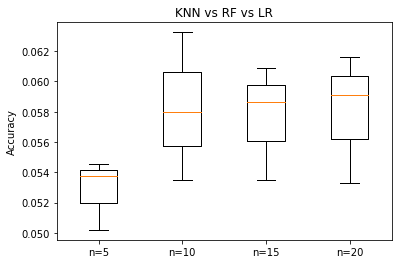

In [22]:
import matplotlib.pyplot as plt

data=[[0.05379,0.05452,0.0502],[0.06325,0.0580,0.05347],[0.06089,0.05867,0.05347],[0.0616,0.0591,0.0533]]
fig, ax = plt.subplots()
plt.title('KNN vs RF vs LR')
plt.ylabel('Accuracy')
ax.boxplot(data)
ax.set_xticklabels(["n=5","n=10","n=15","n=20"])